In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import torch
from tqdm import tqdm
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Data Split

In [3]:
PATH = '/content/drive/MyDrive/PR/data/'

In [4]:
df = pd.read_csv(PATH + 'IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


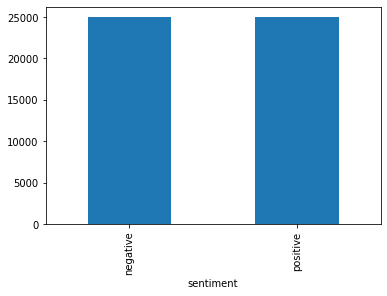

In [5]:
df.groupby(['sentiment']).size().plot.bar()


In [6]:
labels = {'positive' : 0,
         'negative' : 1}

In [7]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

In [8]:
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42, stratify=df_train_val['sentiment'])

# 2.Text Pre-processing


In [9]:
BATCH_SIZE = 16
EPOCHS  = 2
NUM_WORKERS = 2
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
DEVICE

device(type='cuda')

In [10]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]
        sentence = row['review']
        y = labels[row['sentiment']]
        sentence = sentence.lower()
        tokens = self.tokenizer.tokenize(sentence)
        filtered_words = [w for w in tokens if not w in stopwords.words('english')]
        lemmaized = self.lemmatizer.lemmatize(" ".join(filtered_words))
        X = self.bert_tokenizer(lemmaized, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        return X, y

In [ ]:
train_dataset = Dataset(df_train)
test_dataset = Dataset(df_test)
val_dataset = Dataset(df_val)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
len(train_dataloader)

# 3.Classification using BERT

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, h1, h2, h3, h4, dropout=0.5, ):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', num_labels = 2, )
    self.dropout = nn.Dropout(dropout)
    self.l1 = nn.Linear(768, h1)
    self.l2 = nn.Linear(h1, h2)
    self.l3 = nn.Linear(h2, h3)
    self.l4 = nn.Linear(h3, h4)
    self.output = nn.Linear(h4, 1)

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
    x = self.dropout(pooled_output)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = self.l4(x)
    return nn.Sigmoid()(self.output(x))

In [ ]:
def train(model, train_dataloader, val_dataloader, epochs, optimizer, criterion, device):
  best_loss = float('inf')

  for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)
      output = model(input_id, mask)
      batch_loss = criterion(output.reshape((BATCH_SIZE,)), train_label.to(torch.float32))
      total_loss_train += batch_loss.item()
      
      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()
    
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
      for val_input, val_label in tqdm(val_dataloader):
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        batch_loss = criterion(output.reshape((BATCH_SIZE,)), val_label.to(torch.float32))
        # Save Model
        if best_loss > batch_loss:
          best_loss = batch_loss
          torch.save(model, PATH + 'model.pth')

        total_loss_val += batch_loss.item()
        
        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
          
    print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} | Train Accuracy: {total_acc_train / len(df_train): .3f} | Val Loss: {total_loss_val / len(df_val): .3f} | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [ ]:
LR = 1e-3

In [ ]:
model = BertClassifier(512, 256, 128, 64)
model = model.to(DEVICE)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
train(model, train_dataloader, val_dataloader, EPOCHS, optimizer, criterion, DEVICE)

In [ ]:
# Load Model 
model = torch.load(PATH + 'model.pth')

# 4.Validation and Hyperparameter Tuning

# 5.Checking Pre-processing Importance

# 7.Bonus